## 导包和加载模型

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilons = [0, 1/255, 10/255, 20/255, 50/255]
pretrained_model = "./param.pth"

In [3]:
torch.cuda.is_available()

True

In [4]:
#net
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # 卷积层1
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        # 对每个通道的数据进行归一化
        self.batch1 = nn.BatchNorm2d(32)
        # ReLu激活函数
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels =32 , out_channels = 32, kernel_size = 5, stride = 1, padding = 0 )
        self.batch2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        # 最大池化
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # Dropout防止过拟合
        self.conv1_drop = nn.Dropout(0.25)

        # 卷积层2
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0 )
        self.batch4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2_drop = nn.Dropout(0.25)

        # 全连接层1
        
        self.fc1 = nn.Linear(576,256)
        self.fc1_relu = nn.ReLU()
        self.dp1 = nn.Dropout(0.5)
        
        # 全连接层2
        self.fc2 = nn.Linear(256,10)
                
    def forward(self, x):
        # 卷积层1的前向计算
        # print(out.shape)
        # (batch_size,1,28,28)

        out = self.conv1(x)
        out = self.relu1(out)
        out = self.batch1(out)
        # print(out.shape)
        # (batch_size,32,24,24)

        out = self.conv2(out)
        out = self.relu2(out)
        out = self.batch2(out)
        # print(out.shape)
        # (batch_size,32,20,20)

        out = self.maxpool1(out)
        out = self.conv1_drop(out)
        # print(out.shape)
        # (batch_size,32,10,10)

        # 卷积层2的前向计算
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.batch3(out)
        # print(out.shape)        
        # (batch_size,64,8,8)

        out = self.conv4(out)
        out = self.relu4(out)
        out = self.batch4(out)   
        # print(out.shape)
        # (batch_size,64,6,6)

        out = self.maxpool2(out)
        out = self.conv2_drop(out)
        # print(out.shape)
        # (batch_size,64,3,3)

        # Flatten拉平操作
        out = out.view(out.size(0),-1)
        # print(out.shape)
        # (batch_size,576)
        
        # 全连接层的前向计算
        out = self.fc1(out)
        out = self.fc1_relu(out)
        out = self.dp1(out)
        # print(out.shape)
        # (batch_size,256)

        out = self.fc2(out)
        # print(out.shape)
        # (batch_size,10)

        return F.log_softmax(out,dim = 1)

In [5]:
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=1, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Initialize the network
model = CNNModel().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu')) # 加载模型的参数
# model = torch.load(pretrained_model)  # 加载整个模型及其参数

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=576, ou

## FGSM攻击

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 在(0,1)用torch.clamp会和前面DataLoader()中的Normalize((0.1307,), (0.3081,))有冲突，干脆不用

    # Return the perturbed image
    return perturbed_image

In [8]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    tag = [0] * 10

    # Loop over all examples in test set
    for batch_idx, (data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 如果模型最初预测就是错的，就不再攻击这个样本了
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 归零梯度
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        print('\r\t Adversarial Attack Epoch: [{}/{} ({:.0f}%)]\t'.format(
            (batch_idx + 1) * len(data), len(test_loader.dataset),100. * batch_idx / len(test_loader)),end = '')

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
        else:
            # 保存结果图以便后续可视化
            if len(adv_examples) < 20:
                if tag[init_pred.item()] == 0:
                    tag[init_pred.item()] = 1
                    adv_ex = data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), -1, adv_ex) )
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算当前epsilon的准确率
    final_acc = correct/float(len(test_loader))
    print("\tTest Accuracy = {} / {} = {}".format(correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [9]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    print("Epsilons = {:.3f}:".format(eps))
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilons = 0.000:
	 Adversarial Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 9952 / 10000 = 0.9952
Epsilons = 0.004:
	 Adversarial Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 9946 / 10000 = 0.9946
Epsilons = 0.039:
	 Adversarial Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 9874 / 10000 = 0.9874
Epsilons = 0.078:
	 Adversarial Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 9699 / 10000 = 0.9699
Epsilons = 0.196:
	 Adversarial Attack Epoch: [10000/10000 (100%)]		Test Accuracy = 6954 / 10000 = 0.6954


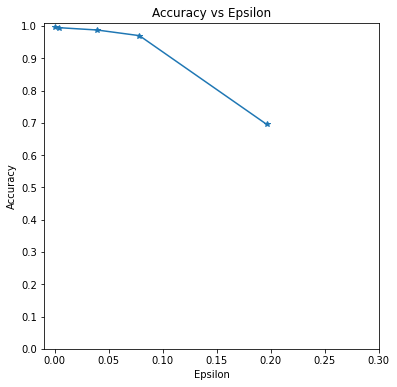

In [10]:
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

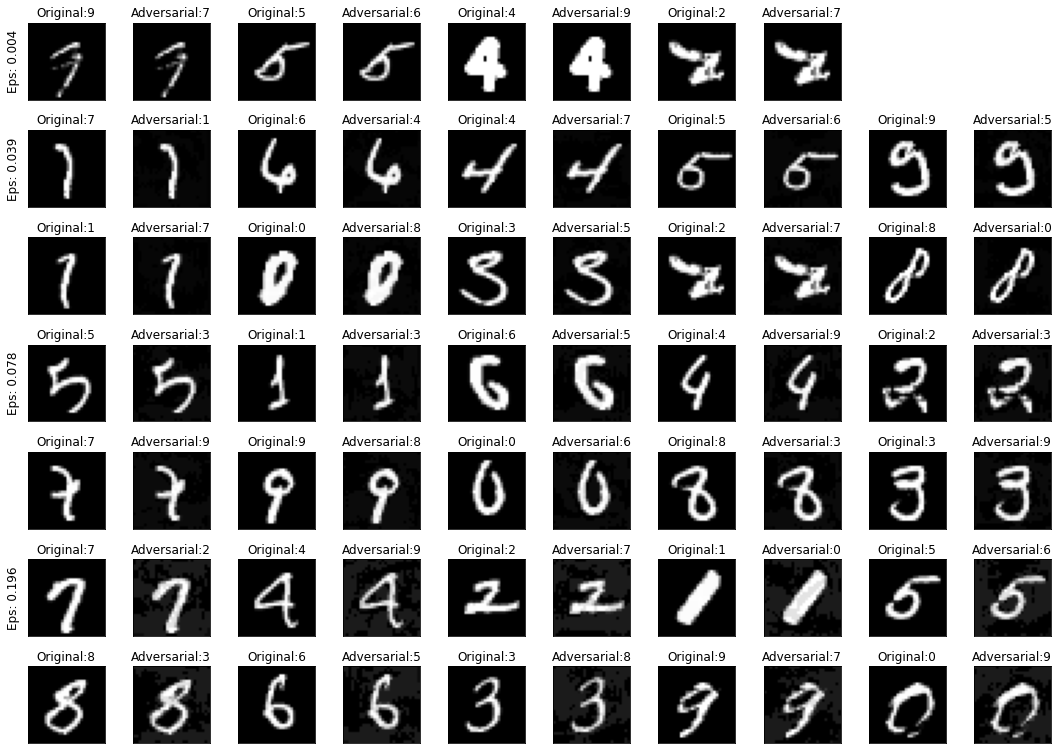

In [11]:
# Plot several examples of adversarial samples at each epsilon
cnt = 1
plt.figure(figsize=(15,15))
for i in range(len(epsilons)):
    if i == 0:
        continue
    for j in range(len(examples[i])):
        if j == 0:
            while cnt%10 != 1:
                cnt+=1
        plt.subplot(len(epsilons)*2,10,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {:.3f}".format(epsilons[i]), fontsize=12)
        orig,adv,ex = examples[i][j]
        if j%2 == 0:
            plt.title("Original:{}".format(orig))
        else:
            plt.title("Adversarial:{}".format(adv))
        plt.imshow(ex, cmap="gray")
        cnt += 1
plt.tight_layout()
plt.show()

- epsilons = [1/255, 10/255, 20/255, 50/255]

    上述四个不同的$\epsilon$取值时，**非定向攻击成功**的部分样本图已经展示如上

- epsilons = **1/255**时，没有攻击成功的样本

    epsilons = **10/255**时，只有四个数字有攻击成功的样本

    epsilons = **20/255** 和 **50/255**时，10个数字都有攻击成功的样本

- 在四个取值下进行对抗攻击后，模型的准确率分别从99.52%降低到了[ 99.46%, 98.74%, 96.99, 69.54%]


In [12]:
accuracies

[0.9952, 0.9946, 0.9874, 0.9699, 0.6954]

## 攻击成功率计算

按照$$攻击成功率=成功次数÷攻击次数$$的公式

由于只攻击了**原模型能够正确预测**的样本，即Epsilon=0时正确的个数，故 **攻击次数**=9952（即每张样本图攻击一次）

四个Epsilon取值下，**成功次数**分别为：9952-9946, 9952-9874, 9952-9699, 9952-6954

故四个取值下成功率分别为：6/9952, 78/9952, 253/9952, 2998/9952

其值如下所示


In [13]:
success_rate = []
for i in range(len(accuracies)):
    if i == 0:
        continue
    success_rate.append((accuracies[0]-accuracies[i])/accuracies[0])
    print(success_rate[i-1])

0.0006028938906751747
0.007837620578778053
0.025422025723472658
0.30124598070739544


即四个Epsilon取值和对应的攻击成功率如下表所示：

| Epsilon | SuccessRate |
| ------- | ----------- |
| 1/255   | 0.06%       |
| 10/255  | 0.78%       |
| 20/255  | 2.54%       |
| 50/255  | 30.12%      |

## 选取Epsilon=50/255的结果进行展示

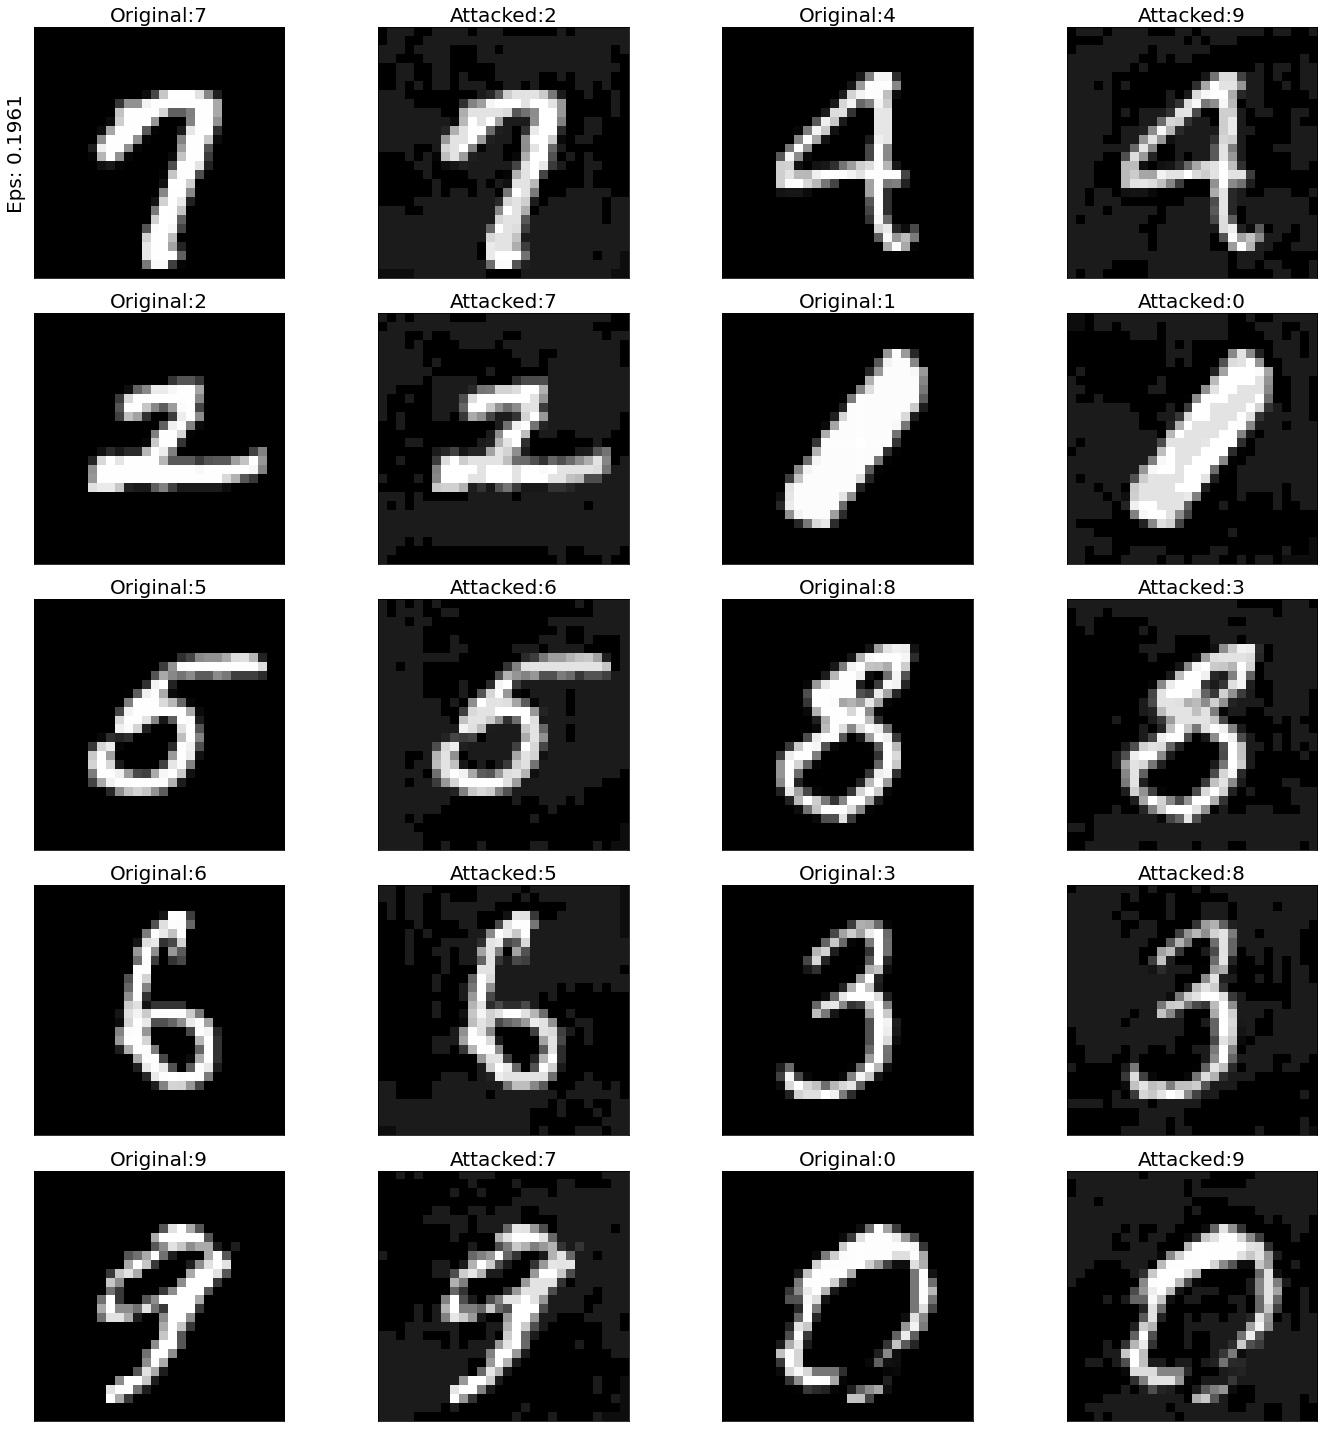

In [14]:
# Plot several examples of adversarial samples at each epsilon
cnt = 1
plt.figure(figsize=(20,20))

for j in range(len(examples[4])):
    if j == 0:
        while cnt%10 != 1:
            cnt+=1
    plt.subplot(5,4,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel("Eps: {:.4f}".format(epsilons[4]), fontsize=20)
    orig,adv,ex = examples[4][j]
    if j%2 == 0:
        plt.title("Original:{}".format(orig), fontsize=20)
    else:
        plt.title("Attacked:{}".format(adv), fontsize=20)
    plt.imshow(ex, cmap="gray")
    cnt += 1
plt.tight_layout()
plt.show()

上面的5行4列的图，表示  **Epsilon=50/255**  时的结果对比图

选取Epsilon=50/255是为了凑齐十个数字都攻击成功的样本，同时仔细观察可以发现一定攻击的痕迹，方便老师确认我已经实施了攻击操作。但不仔细看肉眼还是比较难以发现攻击痕迹的，如果选取更小的Epsilon就更难被肉眼察觉了

Original表示原图和未攻击时的预测结果

Attacked表示攻击后的图片和攻击后的预测结果

共20张子图，包含了10类数字的示例图片

## reference
[ADVERSARIAL EXAMPLE GENERATION](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

[How to load pytorch model](https://discuss.pytorch.org/t/how-to-load-pytorch-model/66432)

[pytorch:torch.clamp()](https://blog.csdn.net/u013230189/article/details/82627375)

[pytorch中归一化transforms.Normalize的真正计算过程](https://zhuanlan.zhihu.com/p/414242338)

[【Python】 【绘图】plt.figure()的使用](https://blog.csdn.net/m0_37362454/article/details/81511427)
